<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

We will parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

**Adapted From:**
* [Official Dask Tutorial](https://github.com/dask/dask-tutorial)

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next part we'll parallelize this code.

In [0]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [127]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.89 ms, sys: 3.04 ms, total: 4.93 ms
Wall time: 3 s


This takes three seconds to run because we call each function sequentially


### Parallelize with the `dask.delayed`

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

In [0]:
from dask import delayed

the delayed function is meant to be used as a decorator like so:

```
@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def add(x, y):
    sleep(1)
    return x + y
```

but since I want to keep the original functions for comparison, I'll call it directly

In [128]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.74 ms, sys: 34 µs, total: 1.77 ms
Wall time: 1.4 ms


**This ran immediately, since nothing has really happened yet.** <br>
The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.

In [129]:
z

Delayed('add-5bd505b1-8762-4d58-8490-e98187920ab1')

 We can visualize the task graph for this value with `.visualize()`:

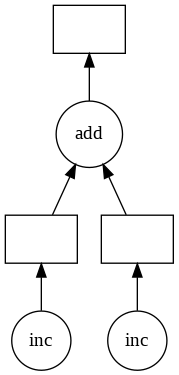

In [130]:
z.visualize()

To get the result, call `compute`. Notice that this runs faster than the original code.

In [131]:
%%time

z.compute()

CPU times: user 3.05 ms, sys: 2.89 ms, total: 5.94 ms
Wall time: 2.01 s


5

### Parallelizing a `for` loop


In [0]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [143]:
%%time

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 7.14 ms, sys: 4.89 ms, total: 12 ms
Wall time: 8.01 s


In [144]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

total.compute()

CPU times: user 8.33 ms, sys: 3.89 ms, total: 12.2 ms
Wall time: 4.01 s


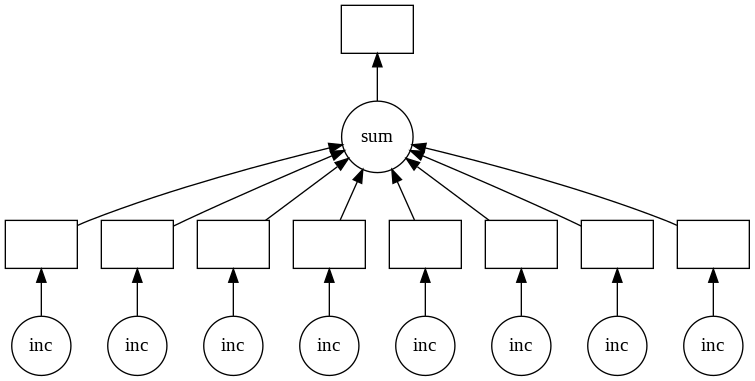

In [145]:
total.visualize()

# Dask DataFrame

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. `dask.dataframe` will scale to datasets much larger than memory. <br>
<br>
The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.
<br>
<br>
Lets try this with an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

In [154]:
# download the NYC Flights dataset to our workspace
import urllib

print("- Downloading NYC Flights dataset... ", end='', flush=True)
url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, headers = urllib.request.urlretrieve(url, 'nycflights.tar.gz')
print("Done!", flush=True)

- Downloading NYC Flights dataset... Done!


In [0]:
import tarfile

# extract the .csv files from the tar file
with tarfile.open(filename, mode='r:gz') as flights:
            flights.extractall('data/')

In [156]:
import os
import dask.dataframe as dd

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

In [159]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,81,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,81,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,81,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,81,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,81,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [160]:
df.tail()

ValueError: ignored

In [0]:
# for coloumns with mixed dtypes we have to infer the correct type
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [162]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,256.0,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,256.0,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,256.0,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,256.0,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,256.0,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## Computations with `dask.dataframe`

We want to compute the maximum of the `DepDelay` column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums. Quite cumbersome. <br>
<br>
`dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel:

In [164]:
%time df.DepDelay.max().compute()

CPU times: user 8.95 s, sys: 253 ms, total: 9.2 s
Wall time: 5.7 s


1435.0

As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

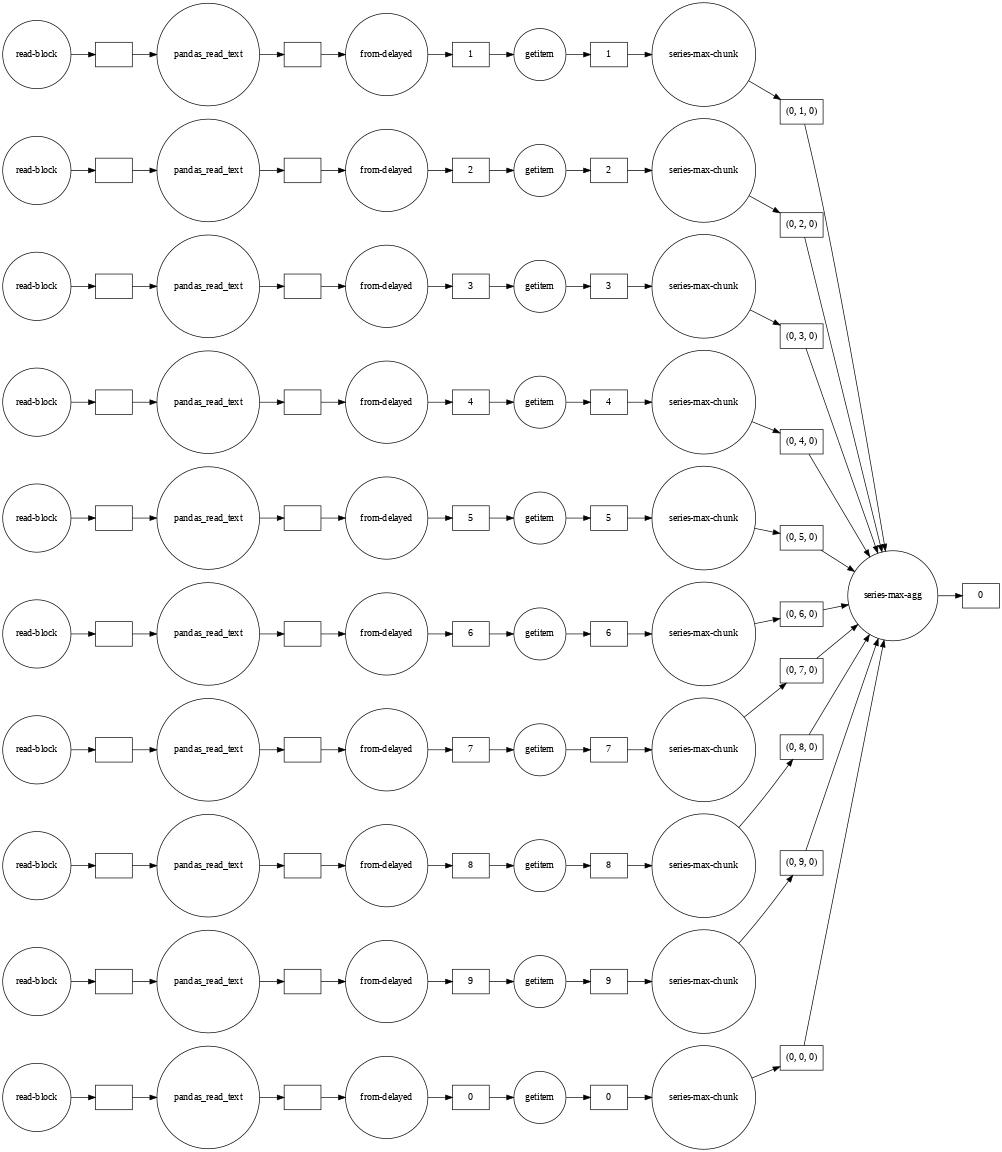

In [165]:
df.DepDelay.max().visualize(rankdir="LR", size="12, 12!")

# Machine Learning with Dask

In [0]:
# You can grab columns from the Dask DataFrame just as you would with Pandas
df_train = df[['CRSDepTime',  'CRSArrTime', 'Cancelled']]

In [181]:
# you can query the shape (note delayed # of samples)
df_train.shape

(Delayed('int-a74dbd0f-b240-41cb-b538-4f020f45c6ea'), 3)

In [182]:
# perform searches and operations on the data
df_train.isnull().sum().compute()

CRSDepTime    0
CRSArrTime    0
Cancelled     0
dtype: int64

In [0]:
from keras.models import Sequential
from keras.layers import Dense

# Build a simple Keras Model
model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd',)

In [0]:
# generate batches of data from our dask dataframe
def dask_data_generator(df, fraction=0.01):
  while True:
    batch = df.sample(frac=fraction)
    X = batch.iloc[:, :-1]
    y = batch.iloc[:, -1]
    yield (X.compute(), y.compute())

In [185]:
# never run out-of-memory while training
model.fit_generator(generator=dask_data_generator(df_train),
                    steps_per_epoch=100)

Epoch 1/1
  9/100 [=>............................] - ETA: 18:51 - loss: 0.4344

KeyboardInterrupt: ignored